# Model - Image Captioning

Here I will run a model to generate captions for objects. This will be done in a few step.  
(Basic approach is an adaptation of the outline from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

1. Extract feature from pretrained network for object recognition.  
2. Using the flicker dataset with labels, train CNN/RNN model 
3. Art Captioning: for this I'll try couple different method
    - test artworks on a model trained for object captioning
    - test artworks on a model trained only for artworks
    - include artworks with description to the training 
    - deeper layers from the object captioning with artwork data
    - *(future) include less concrete object images (e.g. cloud) to the training*

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.applications import NASNetLarge 
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, model_from_json, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import pickle
import os
from timeit import default_timer as timer

import string
import re

In [2]:
import gc

# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

In [3]:
flicker_img_dir = 'IMAGES/Flicker/Flicker8k_Dataset'
flicker_text_dir = 'IMAGES/Flicker/labels'

# Assets Building
First, I will set up all the tools. This includes a dictionary of image_id and its feature extracted using pre-trained network, a dictionary of image_id and associated text description, a class to convert text into sequences then to return 2 inputs (features and text sequence) and output (following sequence). 

## Feature Extraction
---
First, I'll extract features for Flickr images using NASNet network.

In [4]:
def feature_extractor(dir_, network):
    ''' 
    iterate through files in dir_ 
    and get features running on network
    return a dictionary with image id as a key
    '''
    model = network()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    fnames = [x for x in os.listdir(dir_) if x.endswith('.jpg')]
    result = {}
    i = 1
    n = len(fnames)
    
    for fn in fnames:
        img = load_img(f'{dir_}/{fn}', target_size = (331, 331))
        img = np.expand_dims(img, 0)
        img = preprocess_input(img)
        feature = model.predict(img)
        ind = fn.split('.')[0]
        result[ind] = feature
        print(f'{i}/{n} feature extraction completed')
        i += 1
    return result

In [ ]:
# run
features = feature_extractor(flicker_img_dir, NASNetLarge)

In [6]:
# Saving
#with open('PKL/features.pkl', 'wb') as fp:
#    pickle.dump(features, fp, pickle.HIGHEST_PROTOCOL)

In [5]:
# loading
with open('PKL/features.pkl', 'rb') as fp:
    features = pickle.load(fp)

Now for artwork images.

In [30]:
img_dir = 'IMAGES\paintings'
art_features = feature_extractor(img_dir, NASNetLarge)

In [44]:
# saving the extracted features
#with open('PKL/art_features.pkl', 'wb') as fp:
#    pickle.dump(art_features, fp, pickle.HIGHEST_PROTOCOL)

In [6]:
# loading
with open('PKL/art_features.pkl', 'rb') as fp:
    art_features = pickle.load(fp)

## Dictionary of Descriptions
---
I'll create a dictionary with the image id as a key and the descriptions associated with that id as value.  
While I'm at it I'll also remove punctuations, make them lowercase, remove a single letter.

In [13]:
# read the description file
with open(f'{flicker_text_dir}/Flickr8k.token.txt', 'r') as fn:
    text = fn.readlines()

In [14]:
# extract only image id and description
pattern = '([0-9a-z_]*)\.jpg.*\\t(.*)\\n'
p = re.compile(pattern)
descriptions_pairs = [p.findall(x)[0] for x in text]

In [15]:
def description_preprocessing(list_of_tuples, n = None):
    '''
    given description pairs, return a dictionary of descriptions
    if n is specified, only select the n number or less descriptions
    per image
    '''
    descriptions = {}

    table_ = str.maketrans('', '', string.punctuation+string.digits)

    for ind, text in list_of_tuples:
        text = text.lower()
        text = str.translate(text, table_)
        text = [x for x in text.split() if len(x) > 1] # remove trailing alphabet
        text = 'seqini ' + ' '.join(text) + ' seqfin' # add initial and ending tokens
        if ind in descriptions:
            descriptions[ind].append(text)
        else:
            descriptions[ind] = [text]
    if n:
        # if n is assigned cap number of description for each image to be n
        for k, v in descriptions.items():
            if len(v) > n:
                descriptions[k] = list(np.random.choice(v, n, replace = False))
    return descriptions

In [ ]:
# saving
#with open('PKL/descriptions.pkl', 'wb') as fp:
#    pickle.dump(descriptions, fp)

In [7]:
# loading
with open('PKL/descriptions.pkl', 'rb') as fp:
    descriptions = pickle.load(fp)

Now for artwork descriptions

In [8]:
with open('PKL/img_captions1.pkl', 'rb') as fp:
    img_caption1 = pickle.load(fp)
    
# use below for medium description
#with open('PKL/img_captions2.pkl', 'rb') as fp:
#    img_caption2 = pickle.load(fp)

In [16]:
# remove trailing one characters
img_caption = [(k, v) for k, v in img_caption1.items() if v and (len(v) > 1)]
img_ids = [x[0] for x in img_caption]

In [17]:
art_desc = description_preprocessing(img_caption)

## Train/Test/Val Split
---
Now I'll split the list of images into train/val/test sets (70:15:15)

In [18]:
train_list, test_list = train_test_split(list(descriptions.keys()), test_size = 0.3)
val_list, test_list = train_test_split(test_list, test_size = 0.5)

In [19]:
train_list_art, test_list_art = train_test_split((img_ids), test_size = 0.3)
val_list_art, test_list_art = train_test_split(test_list_art, test_size = 0.5)

## Generating Inputs
---
Now we need to create input and output series.  
We need two separate inputs: image features, description as sequences. The output is the next word in the sequence.  

I'll first write some helper functions.

In [5]:
def get_keys(dict_):
    ''' 
    Helper to return a list of keys 
    given dictionary
    '''
    return list(dict_.keys())

def get_vals(dict_):
    ''' 
    Helper to return a list of values 
    given dictionary
    '''
    return list(dict_.values())
    
def get_features(features_dict, img_ind):
    ''' 
    Helper to return feature values 
    given feature dictionary and index
    '''
    if isinstance(img_ind, list):
        return [features_dict[x][0] for x in img_ind]
    elif isinstance(img_ind, str):
        return features_dict[img_ind][0]
    else:
        print('img_ind must be a list or string type')
        return None
    
def get_text(dictionary, img_ind):
    ''' 
    Helper to return a list of description 
    given an index 
    '''
    return dictionary[img_ind]    

Now I will create a sequence generator. This class will basically keep information on feature dictionary, description dictionary, and tokenizer for select list, and generate train/test inputs and outputs.

In [6]:
class sequence_generator:
    def __init__(self, dictionary, features):
        ''' INPUT: a dictionary of descriptions and features '''
        self.dictionary = dictionary
        self.features = features
        self.img_index = get_keys(self.dictionary)
        self.texts = get_vals(self.dictionary)

    def update_selection(self, list_):
        ''' 
        INPUT: select list of image indices
        Create selector, and subsets (select_dictionary, select_img_inds, select_texts)
        '''
        self.selector = list_
        self.select_dictionary = {k: v for k, v in self.dictionary.items() if (k in list_) & (k in self.features)}
        self.select_img_inds = get_keys(self.select_dictionary)
        self.select_texts = get_vals(self.select_dictionary)
    
    def sequence_process(self, dict_):
        ''' Helper to process breakdown on all select dictionary '''
        X1, X2, Y = [], [], []

        def breakdown_sequence(list_):
            ''' Helper to return a list of breakdown sequences and the output '''
            x, y = [], []
            for i in range(1, len(list_)):
                x.append(list_[:i])
                y.append(list_[i])
            return x, y
        
        for ind, texts in dict_.items():
            sequences = self.tokenizer.texts_to_sequences(texts)
            
            for seq in sequences:
                x, y = breakdown_sequence(seq)

                X1.extend(np.repeat(ind, len(y)))
                X2.extend(x)
                Y.extend(y)

        return X1, X2, Y

    def train_generator(self, train_list):
        '''
        INPUT a list of training ids, 
        RETURN image inputs, text inputs, and outputs
        ASSIGN max_length and vocab size
        '''
        self.update_selection(train_list)

        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(np.concatenate(self.select_texts))
        self.num_vocab = len(self.tokenizer.word_index)+1
        
        dict_ = self.select_dictionary
        

        X1, X2, Y = self.sequence_process(dict_)
        
        X2 = pad_sequences(X2)
        self.max_length = X2.shape[1]
    
        Y = to_categorical(Y, self.num_vocab)
        X1 = get_features(self.features, X1)
        return np.array(X1), np.array(X2), np.array(Y)

    def validation_generator(self, val_list):
        '''
        INPUT a list of validation ids, 
        RETURN image inputs, text inputs and outputs
        '''
        self.update_selection(val_list)
        
        dict_ = self.select_dictionary

        X1, X2, Y = self.sequence_process(dict_)
        X2 = pad_sequences(X2, maxlen = self.max_length)
        Y = to_categorical(Y, num_classes = self.num_vocab)
        X1 = get_features(self.features, X1)

        return np.array(X1), np.array(X2), np.array(Y)
    
    def get_num_vocab(self):
        return self.num_vocab
    def get_max_length(self):
        return self.max_length
    def get_tokenizer(self):
        return self.tokenizer

# Model Evaluation
## Iteration 1: Photo Only

Finally, it't time to build the network architecture!  
The network will have two inputs, one for extracted featuers and another for texts. Text sequences will be processed through a simple LSTM. First we will build the model only using the Flickr image and no artworks.

In [29]:
# initialize processor with non-art descriptions and features
processor = sequence_generator(descriptions, features)

In [30]:
# get inputs and output
train_X1, train_X2, train_Y = processor.train_generator(train_list)
val_X1, val_X2, val_Y = processor.validation_generator(val_list)

In [31]:
# get max length and number of vocabularies
max_length = processor.get_max_length()
num_vocab = processor.get_num_vocab()

In [ ]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(256, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(256)(text_layer2)
# outputting
output_layer1 = add([img_layer2, text_layer3])
output_layer2 = Dense(256, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

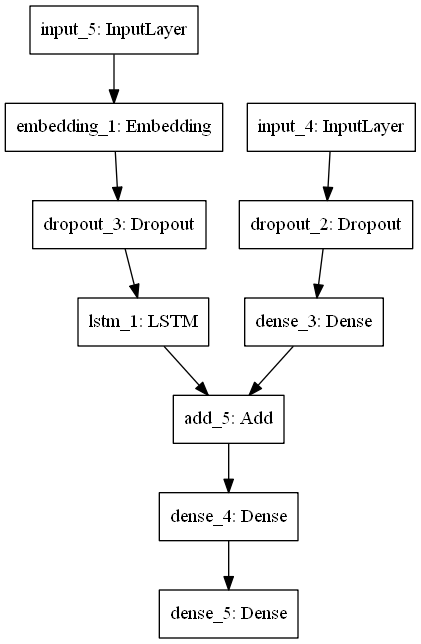

In [316]:
# reviewing structure
plot_model(model, to_file='PNG/basemodel_arch.png')

In [82]:
# saving model
#model.save('MODEL/base_model')

INFO:tensorflow:Assets written to: MODEL/base_model\assets


In [19]:
#loading model
model = load_model('MODEL/base_model')

In [7]:
def plot_performance(hist):
    ''' function to compare training and validation '''
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

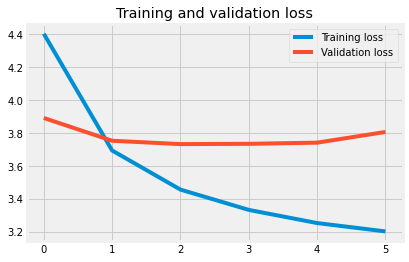

In [83]:
plot_performance(history)

It seems like added epoch is not really helping validation loss. High validation loss is somewhat expected because there are probably a lot of new words in the testing set. Let's try to evaluate how descriptions are translating.

### Iteration 1: evaluation
I'll now predict the model performance. First, I'll get the prediction for each of the testing set. Then the prediction will be compared to the actual captions by BLEU score, which evaluates the translation quality between two texts.

In [32]:
# get the tokenizer
tokenizer = processor.get_tokenizer()

In [12]:
# function to convert word ids to word
def ind2word(ind, tokenizer):
    '''Input: int, output: str'''
    return tokenizer.index_word[ind]

# function to return the prediction 
def caption_generator(img_ind, 
                      feature_dict, 
                      tokenizer, 
                      max_length, 
                     model):
    ''' 
    Input: image id (str), feature_dict, tokenizer, max_length(int)
    Output: a caption
    '''
    
    img_feats = get_features(feature_dict, img_ind)
    img_feats = np.expand_dims(img_feats, axis = 0)
    current_int = tokenizer.texts_to_sequences(['seqini'])
    fin_int = tokenizer.texts_to_sequences(['seqfin'])[0]
    
    # iterate each sequence and predict the next word
    for i in range(max_length):
        current_seq = pad_sequences(current_int, maxlen = max_length)
        next_int = np.argmax(model.predict([img_feats, current_seq]))
        if next_int != fin_int:
            current_int = [current_int[0] + [next_int]]
        else: break
    
    # now translate it into the word
    return ' '.join([ind2word(x, tokenizer) for x in current_seq[0] if x != 0][1:])

Before testing on a full set, let's just take a look at one.

In [13]:
# testing
tmp_desc = caption_generator(test_list[3], features, tokenizer, max_length)
print(tmp_desc)

# display image
img = mpimg.imread(f'{flicker_img_dir}/{test_list[3]}.jpg')
plt.imshow(img)
plt.grid(False)
plt.show()

NameError: name 'test_list' is not defined

It seems like the semantic quality of description is partially correct. But syntactically it's pretty good. Let's run it on all test images and evaluate.

### BLEU (Bilingual Evaluation Understudy Score)
BLEU score is used to evaluate the model performance in translation. It compares the prediction word to word to the set of actual descriptions and returns the value between 0 and 1. 

In [14]:
from nltk.translate.bleu_score import corpus_bleu
# http://www.nltk.org/api/nltk.translate.html

`corpus_bleu()` function from NLTK package primarily takes these arguments:
- list_of_ref: list of correct descriptions 
- hypotheses: prediction to evaluate
- weights: tuple of weights of 1-gram, 2-gram, 3-gram etc.
- smoothing_function: more info here: http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf



In [15]:
def get_bleu(img_inds, 
             feature_dict, 
             tokenizer, 
             max_length, 
             model, 
             text_ref_dict):
    ''' 
    Input takes image index, feature dictionary, 
    tokenizer, max length of tokens, model, 
    and description dictionary 
    Output predictions and BLEU score for 1-gram to 4-gram 
    '''
    prediction_list = {}
    n = len(img_inds)
    hypotheses = []
    references = []
    for i, ind in enumerate(img_inds):
        caption = caption_generator(ind, 
                                    feature_dict, 
                                    tokenizer, 
                                    max_length, 
                                    model)
        prediction_list[ind] = caption
        hypotheses.append(caption.split())
        
        ref = get_text(text_ref_dict, ind)
        references.append([x.split()[1:-1] for x in ref])
        
        print(i+1, '/', n, 'complete')
    bleu_1 = corpus_bleu(references, hypotheses, weights = (1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights = (.5, .5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights = (.3, .3, .3, 0))
    bleu_4 = corpus_bleu(references, hypotheses)

    print(f'1-gram BLEU: {round(bleu_1, 4)}')
    print(f'2-gram BLEU: {round(bleu_2, 4)}')
    print(f'3-gram BLEU: {round(bleu_3, 4)}')
    print(f'4-gram BLEU: {round(bleu_4, 4)}')
    return prediction_list, (bleu_1, bleu_2, bleu_3, bleu_4)

In [ ]:
pred_list, score = get_bleu(test_list)

1-gram BLEU: 0.3199  
2-gram BLEU: 0.1493  
3-gram BLEU: 0.085  
4-gram BLEU: 0.0267

Not super great, but it's not terrible. Usually 1-gram BLEU for decent performance is around .4 - .6.

#### Test on Artworks
As a baseline, let's see how this model that is not trained on artworks do on artwork.

In [17]:
# testing
def test_one_image(img_ind, img_dir, 
                   features, 
                   tokenizer, 
                   max_length, 
                   model):

    tmp_desc = caption_generator(img_ind, features, 
                             tokenizer, max_length, model)
    print(tmp_desc)

    # display image
    img = mpimg.imread(f'{img_dir}/{img_ind}.jpg')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

man in red standing and playing in child of the another


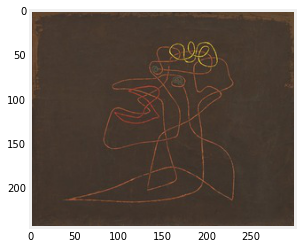

In [320]:
test_one_image(test_list_art[0])

Interestingly wrong. Also the model seems to be fixated on man in red shirt.

In [ ]:
b1_pred_list, b1_score = get_bleu(test_list_art, art_features, tokenizer, 
                            max_length, model, art_desc)

In [ ]:
#b1_pred_list

1-gram BLEU: 0.0403
2-gram BLEU: 0.0096
no 3/4-gram overlaps

Pretty terrible performance. But it's expected as BLEU score calculates how well it matches the reference text, and our art description only has 1 reference and even those were next seen by the machine. Now let's try to feed the art features alone as a training set.

## Iteration 2 - Artworks Only 
Now let's train network only using artworks

In [33]:
# get input/output
processor2 = sequence_generator(art_desc, art_features)
train_X1, train_X2, train_Y = processor2.train_generator(train_list_art)
val_X1, val_X2, val_Y = processor2.validation_generator(val_list_art)

In [39]:
# get params
tokenizer = processor2.get_tokenizer()
max_length = processor2.get_max_length()
num_vocab = processor2.get_num_vocab()

In [ ]:
# architecture
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(256, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(256)(text_layer2)
# outputting
output_layer1 = add([img_layer2, text_layer3])
output_layer2 = Dense(256, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=20, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [336]:
model.save('MODEL/artwork_only_model')

INFO:tensorflow:Assets written to: MODEL/artwork_only_model\assets


In [334]:
#loading model
#model = load_model('MODEL/artwork_only_model')

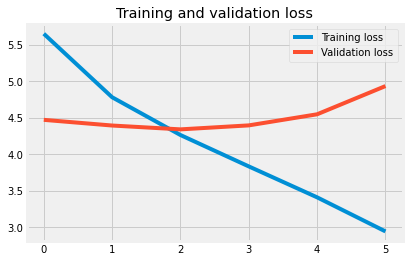

In [337]:
plot_performance(history)

In [ ]:
art_pred_list, art_score = get_bleu(test_list_art, art_features, tokenizer, 
                            max_length, model, art_desc)

1-gram BLEU: 0.0213  
2-gram BLEU: 0.0125  
3-gram BLEU: 0.0124  
4-gram BLEU: 0.0042  

Translation performance is terrible, most of them just did sequences of 'the'. But a very few seems to have the essence captured. Some example below that's not just a sequence of 'the's.

large check


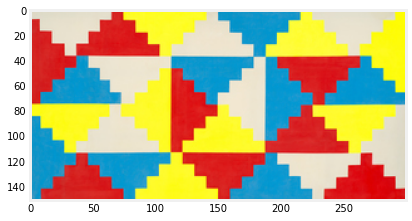

In [346]:
test_one_image('moma_282453', 
              features = art_features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

composition


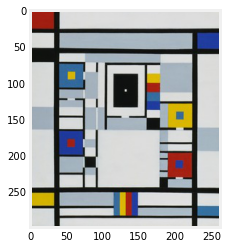

In [344]:
test_one_image('moma_80548', 
              features = art_features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

landscape


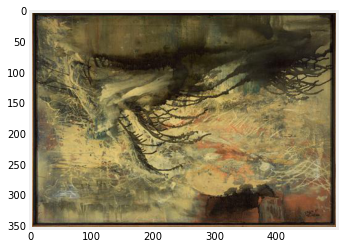

In [345]:
test_one_image('harvard_317590', 
              features = art_features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

Our data clearly does not have enough noise for machine to generalize. Let's try to first train all together with photos.

## Iteration 3: Training both Artworks + Real Life Photos
---
Now I'll train on both artworks and real-life photos.

In [39]:
# combining all descriptions
descriptions.update(art_desc)

In [40]:
# combine all features
features.update(art_features)

In [41]:
# combine train/val sets
train_list_full = train_list_art + train_list
val_list_full = val_list_art + val_list

In [45]:
# generate inputs and outputs
processor3 = sequence_generator(descriptions, features)
train_X1, train_X2, train_Y = processor3.train_generator(train_list_full)
val_X1, val_X2, val_Y = processor3.validation_generator(val_list_full)

In [46]:
# get params
tokenizer = processor3.get_tokenizer()
max_length = processor3.get_max_length()
num_vocab = processor3.get_num_vocab()

In [ ]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(256, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(256)(text_layer2)
# outputting
output_layer1 = add([img_layer2, text_layer3])
output_layer2 = Dense(256, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=20, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [355]:
model.save('MODEL/combined_model_v1')

INFO:tensorflow:Assets written to: MODEL/combined_model_v1\assets


In [72]:
#loading model
#model2 = load_model('MODEL/artwork_only_model')

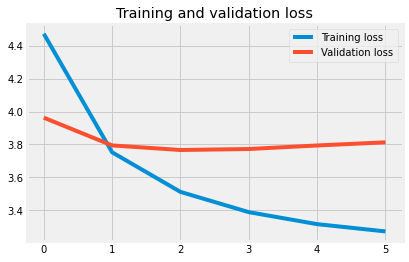

In [356]:
plot_performance(history)

In [ ]:
art_pred_list2, art_score2 = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.0639  
2-gram BLEU: 0.036  
3-gram BLEU: 0.0239  
4-gram BLEU: 0.0091  

Slight improvement, but it is still pretty bad. Let's look at texts it generates.

In [371]:
#art_pred_list2

There are still a lot of meaningless repetition of words. It shows that our model hasn't learned enough meaningful sequences. It's possible that our model is not being trained deep enough.

the black and white dog is running through the snow


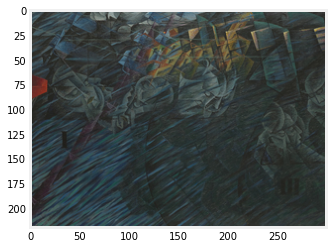

In [360]:
test_one_image('moma_78653', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

the man is standing on the floor


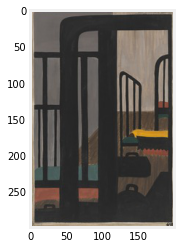

In [362]:
test_one_image('moma_78543', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

## Iteration 4. Deeper Architecture
---
To add a depth, I'll add one more LSTM layer. This time I'll also force it to run longer and intentionally overfit.

In [ ]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(256, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(256, return_sequences = True)(text_layer2)
text_layer4 = Dropout(0.5)(text_layer3)
text_layer5 = LSTM(256)(text_layer4)
# outputting
output_layer1 = add([img_layer2, text_layer5])
output_layer2 = Dense(256, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v2')
# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=15, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 8, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [370]:
#loading model
model2 = load_model('MODEL/combined_model_v2')

In [ ]:
art_pred_list3, art_score3 = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model2, descriptions)

1-gram BLEU: 0.0899  
2-gram BLEU: 0.0534  
3-gram BLEU: 0.0451  
4-gram BLEU: 0.0139  
(slight improvement)

It seems like the sequence of same words (e.g. 'the the the') is much reduced this round, even though it's still not great. Let's take a look at some of the full sentences.

two people are sitting on the grass


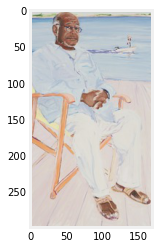

In [377]:
test_one_image('moma_80579', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model2)

man in black shirt is standing on the beach


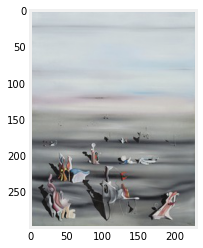

In [378]:
test_one_image('moma_80625', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model2)

portrait of person


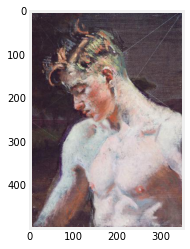

In [380]:
test_one_image('harvard_230848', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model2)

portrait of older man in white shorts and sunglasses and sunglasses


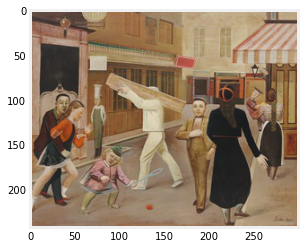

In [381]:
test_one_image('moma_80582', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model2)

I also want to evaluate if this model is generally doing well overall.

In [ ]:
# testing on photo data
pred_list3, score3 = get_bleu(test_list, features, tokenizer, 
                            max_length, model2, descriptions)

Performance for any image has improved as well.  
1-gram BLEU: 0.4691  
2-gram BLEU: 0.2675  
3-gram BLEU: 0.1809  
4-gram BLEU: 0.0828  

It seems like the performance on the real life images have improved by a lot. 

## Iteration 5
---

Our data tend to overfit very quickly, which is reasonable given that there are a lot of vocabularies and probably many are not familiar to the model. I'll try to add one more dropout layer and I'll also increase overall unit size. This is going to get computationally very expensive since our flickr dataset can lead to more than 20k instances (1 per each description). So I'm going to reduce the number of description per image to be 2.

In [63]:
# cap description at 2 per image
condensed_desc = description_preprocessing(descriptions_pairs, 2)
# add art
condensed_desc.update(art_desc)

In [ ]:
# generate inputs and outputs
processor4 = sequence_generator(condensed_desc, features)
train_X1, train_X2, train_Y = processor4.train_generator(train_list_full)
val_X1, val_X2, val_Y = processor4.validation_generator(val_list_full)

In [65]:
# get params
tokenizer = processor4.get_tokenizer()
max_length = processor4.get_max_length()
num_vocab = processor4.get_num_vocab()

In [66]:
num_vocab

6592

In [67]:
len(train_Y)

124530

In [ ]:
# model architecture
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(512, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 512, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(512, return_sequences = True)(text_layer2)
text_layer4 = Dropout(0.5)(text_layer3)
text_layer5 = LSTM(512)(text_layer4)
text_layer6 = Dropout(0.5)(text_layer5) # new dropout

# outputting
output_layer1 = add([img_layer2, text_layer6])
output_layer2 = Dense(512, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v3')
# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=5, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 8, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

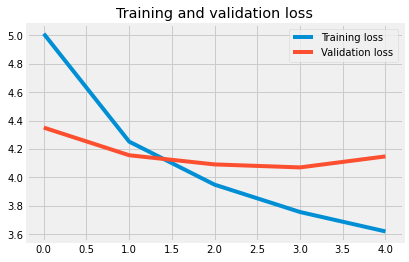

In [90]:
plot_performance(history)

In [ ]:
# testing on photo data
pred_list4, score4 = get_bleu(test_list, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.4787  
2-gram BLEU: 0.2638  
3-gram BLEU: 0.1689  
4-gram BLEU: 0.0742  
3-gram and 4-gram BLEU dropped slightly but 1-gram improved. So it's classifying some of the objects better.

In [106]:
#pred_list4

man in blue shorts is playing in the air


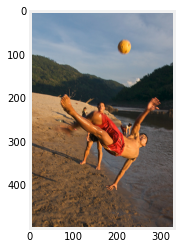

In [101]:
# testing
tmp_desc = caption_generator('3222250187_ef610f267e', features, tokenizer, max_length, model)
print(tmp_desc)

# display image
img = mpimg.imread(f'{flicker_img_dir}/3222250187_ef610f267e.jpg')
plt.imshow(img)
plt.grid(False)
plt.show()

In [ ]:
# testing on art data
art_pred_list4, art_score4 = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.0636  
2-gram BLEU: 0.0339  
3-gram BLEU: 0.0305  
4-gram BLEU: 0.0127  

In [107]:
#art_pred_list4

cantonese painting of fish


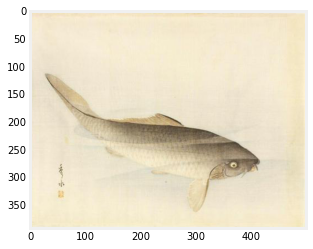

In [104]:
test_one_image('risd_1038771', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

the black dog is standing on the water


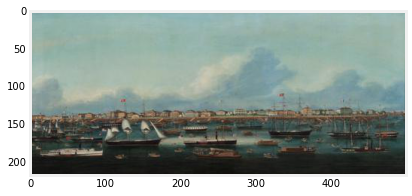

In [105]:
test_one_image('harvard_310952', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

## Iteration 6
---
The model needs to find some more patterns. I'll first try to run the previous model a few more epochs. It's already overfitting in terms of validation loss, but it's clear that the model has not learned 'enough'.

In [ ]:
#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v4')
# training
start = timer()

history2 = model.fit([train_X1, train_X2], train_Y, 
                     initial_epoch = 5,
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 8, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [ ]:
# testing on photo data
pred_list5, score5 = get_bleu(test_list, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.4659  
2-gram BLEU: 0.2658  
3-gram BLEU: 0.1793  
4-gram BLEU: 0.0791  
Adding more epochs slightly reduced the unigram score, but improved the higher n-grams.

In [124]:
#pred_list5

the little boy in the blue shirt is kicking soccer ball


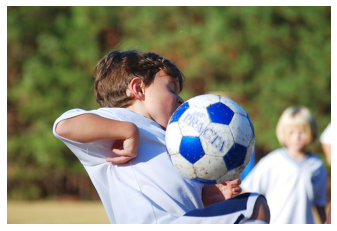

In [127]:
# testing
tmp_desc = caption_generator('1680126311_b92a2e8e72', features, tokenizer, max_length, model)
print(tmp_desc)

# display image
img = mpimg.imread(f'{flicker_img_dir}/1680126311_b92a2e8e72.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

two dogs are running on the track


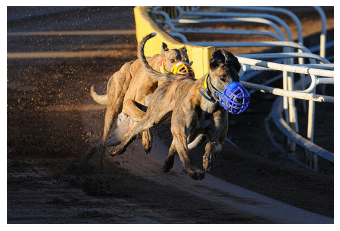

In [126]:
# testing
tmp_desc = caption_generator('3097196395_ec06075389', features, tokenizer, max_length, model)
print(tmp_desc)

# display image
img = mpimg.imread(f'{flicker_img_dir}/3097196395_ec06075389.jpg')
plt.imshow(img)
#plt.grid(False)
plt.axis('off')
plt.show()

In [ ]:
# testing on art data
art_pred_list5, art_score5 = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.0567  
2-gram BLEU: 0.0315  
3-gram BLEU: 0.0293  
4-gram BLEU: 0.0115  

In [141]:
#art_pred_list5

portrait of young man in mirror


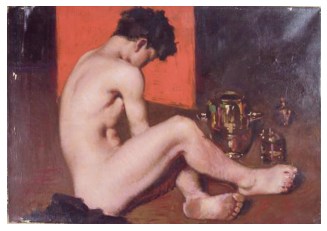

In [139]:
test_one_image('harvard_226455', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

the landscape


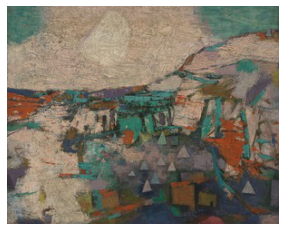

In [140]:
test_one_image('moma_78590', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

Art descriptions generated by the model is still mostly faulty. Also based on the score, it seems like some of the details (e.g. colors) are not being picked up by the model yet. Training loss is still pretty high as well.

In [68]:
# reviewing structure
#plot_model(model, to_file='PNG/iter6_arch.png')

## Iteration 7
---
Stacking one more layer to deepen the structural abstraction. This is more experimental.

In [ ]:
# model architecture
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(512, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 512, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(512, return_sequences = True)(text_layer2)
text_layer4 = Dropout(0.5)(text_layer3)
text_layer5 = LSTM(512, return_sequences = True)(text_layer4)
text_layer6 = Dropout(0.5)(text_layer5)
text_layer7 = LSTM(512)(text_layer6)

# outputting
output_layer1 = add([img_layer2, text_layer7])
output_layer2 = Dense(512, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v4')

In [ ]:
# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y,
                    initial_epoch=3,
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [ ]:
# testing on photo data
pred_list6, score6 = get_bleu(test_list, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.4269  
2-gram BLEU: 0.245  
3-gram BLEU: 0.1688  
4-gram BLEU: 0.0794  
That did not really help the performance.

In [ ]:
# testing on art data
art_pred_list6, art_score6 = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.111  
2-gram BLEU: 0.0699  
3-gram BLEU: 0.0631  
4-gram BLEU: 0.0268  
But improved the art title words

In [157]:
#art_pred_list6

the man in the blue shirt is standing on the river


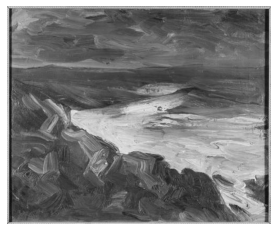

In [153]:
test_one_image('harvard_231632', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

the elephant of the sun


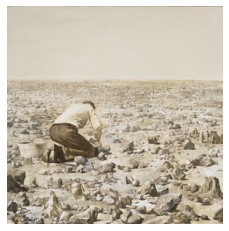

In [154]:
test_one_image('moma_79167', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model)

It's starting to get a little poetic.

## Iteration 8
The problem with the general captioning seems to be that it's not able to pick up the accurate semantics. Maybe giving it some pre-trained word embedding weights can help establish that relationship quicker.

### GloVe 
I'll calculate word embedding weights to use for our model.

In [158]:
from gensim.models import word2vec

In [159]:
# building GloVe dictionary
glove_path_pc = 'D:\Projects\GloVe_6B\glove.6B.300d.txt'
glove_dict = {}
with open(glove_path_pc, 'r', encoding = 'utf-8') as f:
    for line in f:
        vals = line.split(' ')
        glove_dict[vals[0]] = np.asarray(vals[1:], dtype = 'float32')

In [160]:
# save dictionary
#with open ('PKL/GloVe_dict.pkl', 'wb') as fp:
#    pickle.dump(glove_dict, fp)

In [53]:
# load dictionary
with open ('PKL/GloVe_dict.pkl', 'rb') as fp:
    glove_dict = pickle.load(fp)

In [54]:
tokenizer = processor4.get_tokenizer()

In [55]:
# get embeddings for each word from the GloVe
word_emb_mat = np.zeros((num_vocab, 300))
for i in range(1, num_vocab):
    word = tokenizer.index_word[i]
    if word in glove_dict:
        word_emb_mat[i] = glove_dict[word]

Now run the model with the weights.

In [168]:
# model architecture
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(256, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 300, weights = [word_emb_mat],
                        mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(256, dropout = 0.5, return_sequences = True)(text_layer2)
text_layer4 = LSTM(256, dropout = 0.5, return_sequences = True)(text_layer3)
text_layer5 = LSTM(256, dropout = 0.5)(text_layer4)

# outputting
output_layer1 = add([img_layer2, text_layer5])
output_layer2 = Dense(256, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v5')

In [ ]:
# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y,
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [45]:
model = load_model('MODEL/combined_model_v5')

In [ ]:
# testing on photo data
pred_list7, score7 = get_bleu(test_list, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.3609  
2-gram BLEU: 0.1521  
3-gram BLEU: 0.0775  
4-gram BLEU: 0.0194  
It got so much worse. 

In [ ]:
# testing on art data
art_pred_list7, art_score7 = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.014  
2-gram BLEU: 0.0053   
3-gram BLEU: 0.0  
4-gram BLEU: 0.0  
Also really bad performance predicting words. I wonder if there was something wrong with the code or overall approach. 

## Iteration 9
I think I should try to run the best model so far more epochs.

In [69]:
# model architecture
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(512, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 512, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(512, dropout = 0.5, return_sequences = True)(text_layer2)
text_layer4 = LSTM(512, dropout = 0.5, return_sequences = True)(text_layer3)
text_layer5 = LSTM(512, dropout = 0.5)(text_layer4)

# outputting
output_layer1 = add([img_layer2, text_layer5])
output_layer2 = Dense(512, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v9')

In [ ]:
start = timer()

history = model.fit([train_X1, train_X2], train_Y,
                    epochs=20, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = -1, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [18]:
with open('PKL/condendsed_descriptions.pkl', 'rb') as fp:
    descriptions = pickle.load(fp)
    
with open('PKL/full_features.pkl', 'rb') as fp:
    features = pickle.load(fp)
    
with open('PKL/train_list_full.pkl', 'rb') as fp:
    train_list_full = pickle.load(fp)

with open('PKL/val_list_full.pkl', 'rb') as fp:
    val_list_full = pickle.load(fp)
    
with open('PKL/test_list.pkl', 'rb') as fp:
    test_list = pickle.load(fp)
    
with open('PKL/test_list_art.pkl', 'rb') as fp:
    test_list_art = pickle.load(fp)

In [19]:
model = load_model('MODEL/combined_model_v9')

In [22]:
# generate inputs and outputs
processor = sequence_generator(descriptions, features)
train_X1, train_X2, train_Y = processor.train_generator(train_list_full)
val_X1, val_X2, val_Y = processor.validation_generator(val_list_full)

In [23]:
# get params
tokenizer = processor.get_tokenizer()
max_length = processor.get_max_length()
num_vocab = processor.get_num_vocab()

In [ ]:
# testing on photo data
fin_pred_list, fin_score = get_bleu(test_list, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.2146  
2-gram BLEU: 0.0777  
3-gram BLEU: 0.0415  
4-gram BLEU: 0.0098  

Significantly worse performance as expected with overfit model.

In [ ]:
# testing on art data
fin_art_pred_list, fin_art_score = get_bleu(test_list_art, features, tokenizer, 
                            max_length, model, descriptions)

1-gram BLEU: 0.0415  
2-gram BLEU: 0.0101  
3-gram BLEU: 0.0  
4-gram BLEU: 0.0  

Syntactically totally wrong, but it started to make some out-of-the box connections.

hoop walking galli heroicus


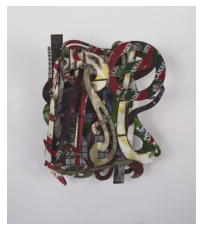

In [31]:
test_one_image('moma_80442', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model, 
              img_dir = img_dir)

fluffy sunglasses dog steps


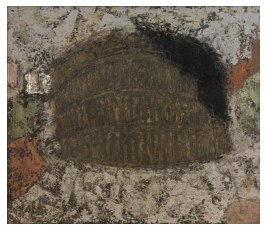

In [32]:
test_one_image('risd_798501', 
              features = features, 
              tokenizer = tokenizer, 
              max_length = max_length,
              model = model, 
              img_dir = img_dir)

## Export
Here I will take time to export the files so we can migrate the whole process to the AWS Sagemaker. 

In [ ]:
with open('PKL/train_list_full.pkl', 'wb') as fp:
    pickle.dump(train_list_full, fp)

with open('PKL/val_list_full.pkl', 'wb') as fp:
    pickle.dump(val_list_full, fp)
    
with open('PKL/test_list.pkl', 'wb') as fp:
    pickle.dump(test_list, fp)
    
with open('PKL/test_list_art.pkl', 'wb') as fp:
    pickle.dump(test_list_art, fp)

with open('PKL/condensed_descriptions.pkl', 'wb') as fp:
    pickle.dump(condensed_desc, fp)
    
with open('PKL/full_features.pkl', 'wb') as fp:
     pickle.dump(features, fp)